#Per ottenere i vettori del vocabolario
https://github.com/vijayaiitk/NLP-text-classification-model/issues/1

Prendi le parole più simili
https://aneesha.medium.com/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
https://stackoverflow.com/questions/37818426/get-most-similar-words-given-the-vector-of-the-word-not-the-word-itself
https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html

In [22]:
# usare i lessici

In [8]:
import pandas as pd
import nltk
import numpy as np
import string

import gensim
from mi_helper import *
from sklearn.pipeline import Pipeline

from numpy import array 
from numpy import dot
from numpy.linalg import norm

In [2]:
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases

In [3]:
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import wordnet
import re

In [4]:
custom_stopwords = ['echo',
 'alexa',
 'dot',
 "star",
 'amazon',
 'prime',
 '2nd',
 'generation',
 "fire",
 "stick",
 "firestick",
 '1st',
 '3rd',
 '4th',
 '5th',
 'google',
 'netflix',
 'youtube',
 'philip',
 'tp-link',
 'fourth',
 'roku',
 'i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'nor',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 's',
 't',
 'can',
 'will',
 'just',
 'don',
 "...",
 'should',
 "should've",
 'now',
 'd',
 'll',
 'm',
 'o',
 're',
 've',
 'y',
 'ain',
 'aren',
 "aren't",
 'couldn',
 'didn',
 'doesn',
 'hadn',
 'hasn',
 'haven',
 'isn',
 'ma',
 'mightn',
 "mightn't",
 'mustn',
 "mustn't",
 'needn',
 "needn't",
 'shan',
 "shan't",
 'shouldn',
 'wasn',
 'weren',
 'won',
 'wouldn']

def negation_handler(sentence):	
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't"]:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wordnet.synsets(ant)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp>max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        sentence[i] = antonym_max
                        sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence

In [5]:
negation_handler(["n't", "wait"] )

["n't", 'wait']

In [6]:
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [10]:
import gensim.downloader as api
google_model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [17]:
w2v_google = {}
for word, vector in zip(google_model.index_to_key, google_model.vectors):
    w2v_google[word] = vector

In [46]:
google_model.relative_cosine_similarity("love", "hate")

0.09877196713935217

In [217]:
dataset = pd.read_csv("amazon_alexa.tsv", sep = "\t")
dataset.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1
3149,4,29-Jul-18,Black Dot,Good,1


In [218]:
# dataset.drop(dataset[dataset.rating == 3].index, inplace=True) #droppa recensioni con 3-4 stelle
# dataset.drop(dataset[dataset.rating == 4].index, inplace=True)

In [219]:
# CREAZIONE DI UN SAMPLE DATASET BILANCIATO
# prende le prime n recensioni positive di lunghezza maggiore, dove n è il numero di recensioni negative
def create_balanced_dataset(dataset):
    """Bilancia il dataset uniformando il numero di recensioni negative e positive. Prende in input il dataset"""
    reviews_1 = list(dataset[dataset["feedback"] == 1]["verified_reviews"])
    reviews_0 = list(dataset[dataset["feedback"] == 0]["verified_reviews"])
    reviews_1.sort(key=len, reverse = True)
    sample_1 = reviews_1[:len(reviews_0)]
    verified_reviews_sample = []
    feedback_sample = []
    verified_reviews_sample.extend(sample_1)
    verified_reviews_sample.extend(reviews_0)
    feedback_sample.extend([1 for i in range(len(sample_1))])
    feedback_sample.extend([0 for i in range(len(reviews_0))])
    dataset = pd.DataFrame({"verified_reviews":verified_reviews_sample, "feedback": feedback_sample})
    print(dataset["feedback"].value_counts())
    return dataset


# dataset = create_balanced_dataset(dataset)

In [189]:
sentences = []

for review in dataset["verified_reviews"]:
    sents = sent_tokenize(review)
    for sent in sents:
        sentences.append(sent)
sentences


['Love my Echo!',
 'Loved it!',
 'Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.',
 'I like being able to turn lights on and off while away from home.',
 'I have had a lot of fun with this thing.',
 'My 4 yr old learns about dinosaurs, i control the lights and play games like categories.',
 'Has nice sound when playing music as well.',
 'Music',
 'I received the echo as a gift.',
 'I needed another Bluetooth or something to play music easily accessible, and found this smart speaker.',
 'Can’t wait to see what else it can do.',
 'Without having a cellphone, I cannot use many of her features.',
 'I have an iPad but do not see that of any use.',
 'It IS a great alarm.',
 'If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.',
 'She does not seem to be very smartbon politics yet.',
 "

In [190]:
def get_wordnet_pos(treebank_tag):
    """
    return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
    """
    if treebank_tag.startswith('J'):
        return "a"
    elif treebank_tag.startswith('V'):
        return "v"
    elif treebank_tag.startswith('N'):
        return "n"
    elif treebank_tag.startswith('R'):
        return "r"
    else:
        return "n"
        
pos_list = ["JJ", "JJR", "JJS", "RB", "RBR", "RBS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]

def tokenize_list_of_text(list_of_text, custom_stopwords = [], pos_filter = False, pos_list = []):
    """Tokenizza tutte le recensioni, pulisce da stopwords, elimina token <= 2 caratteri e lemmatizza. Ritorna la colonna delle recensioni."""

    tokenizer = nltk.tokenize.TweetTokenizer()
    lemmatizer = nltk.WordNetLemmatizer()
    detokenizer = TreebankWordDetokenizer()

    tokenized_reviews = []
    sent_tokenized_reviews = []
    for review in list_of_text: #pulisce le recensioni
        review = re.sub(r'\d+', '', review)
        clean_text = ""
        tokens = nltk.tokenize.word_tokenize(review, language='english', preserve_line=False)
        tokens = negation_handler(tokens)
        tokens = [w.lower() for w in tokens]
        tokens_pos = pos_tag(tokens)
        lemmatized_tokens = [(lemmatizer.lemmatize(w, get_wordnet_pos(pos)), pos) for w, pos in tokens_pos]
        if pos_filter:
            clean_tokens = [(w, pos) for w, pos in lemmatized_tokens if w not in string.punctuation and len(w)>2 and w not in custom_stopwords and pos in pos_list]
        else:
            clean_tokens = [(w, pos) for w, pos in lemmatized_tokens if w not in string.punctuation and len(w)>2 and w not in custom_stopwords]
        sent_tokenized_reviews.append([w for w, pos in clean_tokens])
        tokenized_reviews.append(detokenizer.detokenize([w for w, pos in clean_tokens]))
    
    n_tokens = []
    for sent in sent_tokenized_reviews:
        for w in sent:
            n_tokens.append(w)
    print("total number of tokens extracted are:", len(set(n_tokens)))
    return tokenized_reviews,  sent_tokenized_reviews # ritorna una tupla!

In [191]:
new_text, new_sent_tok = tokenize_list_of_text(sentences, custom_stopwords, False, pos_list)
# contengono una lista di tutte le frasi pre processate, nella prima variabile in stringa, nella seconda in tokens 

total number of tokens extracted are: 3339


In [192]:
bigrams = Phrases(new_sent_tok)
bigrams[new_sent_tok][34]

['really', 'happy_purchase']

In [220]:
#window = numero di token, min_num = frequenza minima dei token, sg = traing algorithm - skip-gram, negative = negative example
#aggiorna soltato un numero k di pesi nella rete per le parole più informative 

w2v_model = Word2Vec(bigrams[new_sent_tok], vector_size=100, window = 5, min_count = 5, sg=1, epochs=30, hs = 1)

# w2v_model = Word2Vec(new_sent_tok, vector_size=100, window = 2, min_count = 5, sg=0, epochs=20, hs = 1)

In [221]:
len(w2v_model.wv.vectors)

1020

In [222]:
w2v_model.wv.most_similar(['love'], topn = 2000) #Nearest neighboor --> high cosine similarity

[('sing', 0.49555081129074097),
 ('grand', 0.4494123160839081),
 ('wonderful', 0.444284051656723),
 ('great', 0.443918913602829),
 ('cool', 0.4309692084789276),
 ('shopping_list', 0.4287492334842682),
 ('like', 0.4281421899795532),
 ('really_enjoy', 0.4269377887248993),
 ('timer', 0.39948636293411255),
 ('favorite_song', 0.39879855513572693),
 ('lyric', 0.3975685238838196),
 ('lyric_song', 0.39465731382369995),
 ('spot', 0.3911922872066498),
 ('play_game', 0.3905695974826813),
 ('remind', 0.3812062740325928),
 ('watch_video', 0.3774976432323456),
 ('man', 0.3765897750854492),
 ('trivia', 0.37468427419662476),
 ('live', 0.37267768383026123),
 ('shop', 0.371396541595459),
 ('put', 0.36782634258270264),
 ('father_day', 0.3670072853565216),
 ('homework', 0.3650173246860504),
 ('cook', 0.36440643668174744),
 ('neat', 0.3614019453525543),
 ('clean', 0.35921475291252136),
 ('nice', 0.35880690813064575),
 ('pleased', 0.35745951533317566),
 ('watching', 0.355514258146286),
 ('skype', 0.35505738

In [223]:
w2v_model.wv.most_similar(['love'], topn = len(w2v_model.wv.vectors))[-20:] # less similar words

[('although', -0.01689731702208519),
 ('none', -0.017328666523098946),
 ('bluetooth_speaker', -0.01743858866393566),
 ('end', -0.01824788749217987),
 ('around', -0.01835872046649456),
 ('maybe', -0.019757192581892014),
 ('full', -0.025153828784823418),
 ('build_hub', -0.025654658675193787),
 ('reason', -0.0316208153963089),
 ('issue', -0.03824691101908684),
 ('something', -0.04051743820309639),
 ('today', -0.040847908705472946),
 ('spend', -0.05706722289323807),
 ('sale', -0.05736326798796654),
 ('connectivity', -0.058610882610082626),
 ('seamlessly', -0.05885104835033417),
 ('often', -0.06526421010494232),
 ('hue', -0.06909262388944626),
 ('hue_bridge', -0.0697692409157753),
 ('range', -0.07838644087314606)]

In [224]:
w2v_model.wv.vectors[0] # contiene i vettori

array([ 0.23879257,  0.142663  ,  0.38444075,  0.1299887 , -0.00577294,
       -0.14832343,  0.3191996 ,  0.41368327, -0.05620225, -0.24659014,
        0.06112341, -0.21443434, -0.30045447, -0.28434214,  0.01676081,
       -0.15036166,  0.11276997,  0.23027295, -0.25355515,  0.00166852,
        0.4656025 ,  0.01162472,  0.29159352,  0.04851538, -0.00104219,
        0.15372333,  0.01802837,  0.10985817, -0.27928224, -0.00331298,
        0.42090204, -0.3059957 , -0.03925965, -0.49634355, -0.04759924,
       -0.00630937,  0.15887633, -0.10963469, -0.23351546, -0.06049449,
       -0.1980295 , -0.23999615,  0.0514124 ,  0.1112914 ,  0.12647553,
        0.2758971 , -0.5442084 ,  0.04107453,  0.21922114,  0.49600315,
       -0.13912287, -0.13950925,  0.02912281, -0.02928846, -0.3138205 ,
        0.03536047,  0.00202469,  0.23464438, -0.3408054 ,  0.06128806,
        0.17462689,  0.29641607, -0.2692056 ,  0.14083818, -0.43449855,
        0.02576829,  0.14517027, -0.19997865, -0.07422591,  0.04

The structure is called “KeyedVectors” and is essentially a mapping between keys and vectors. Each vector is identified by its lookup key, most often a short string token, so this is usually a mapping between {str => 1D numpy array}
https://radimrehurek.com/gensim/models/keyedvectors.html

Other useful internals in Gensim 4.0+ include model.wv.index_to_key, a plain list of the key (word) in each index position, and model.wv.key_to_index, a plain dict mapping keys (words) to their index positions.

In [225]:
w2v_model.wv.key_to_index

{'love': 0,
 'great': 1,
 'use': 2,
 'like': 3,
 'get': 4,
 'work': 5,
 'good': 6,
 'one': 7,
 'device': 8,
 'music': 9,
 'sound': 10,
 'buy': 11,
 'not': 12,
 'product': 13,
 'thing': 14,
 'speaker': 15,
 'time': 16,
 'would': 17,
 'show': 18,
 'set': 19,
 'easy': 20,
 'new': 21,
 'really': 22,
 'much': 23,
 'day': 24,
 'also': 25,
 'home': 26,
 'purchase': 27,
 'play': 28,
 'need': 29,
 'want': 30,
 'far': 31,
 'make': 32,
 'ask': 33,
 'well': 34,
 'play_music': 35,
 'fun': 36,
 'connect': 37,
 'say': 38,
 "n't": 39,
 'still': 40,
 'think': 41,
 'easy_set': 42,
 'try': 43,
 'plus': 44,
 'everything': 45,
 'smart': 46,
 'little': 47,
 'screen': 48,
 'even': 49,
 'tell': 50,
 'room': 51,
 'able': 52,
 'spot': 53,
 'could': 54,
 'feature': 55,
 'nice': 56,
 'light': 57,
 'sound_quality': 58,
 'alarm': 59,
 'see': 60,
 'add': 61,
 'price': 62,
 'house': 63,
 'find': 64,
 'know': 65,
 'come': 66,
 'give': 67,
 'another': 68,
 'learn': 69,
 'way': 70,
 'turn': 71,
 'without': 72,
 'bedroom

In [226]:
w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors))
w2v

{'love': array([ 0.23879257,  0.142663  ,  0.38444075,  0.1299887 , -0.00577294,
        -0.14832343,  0.3191996 ,  0.41368327, -0.05620225, -0.24659014,
         0.06112341, -0.21443434, -0.30045447, -0.28434214,  0.01676081,
        -0.15036166,  0.11276997,  0.23027295, -0.25355515,  0.00166852,
         0.4656025 ,  0.01162472,  0.29159352,  0.04851538, -0.00104219,
         0.15372333,  0.01802837,  0.10985817, -0.27928224, -0.00331298,
         0.42090204, -0.3059957 , -0.03925965, -0.49634355, -0.04759924,
        -0.00630937,  0.15887633, -0.10963469, -0.23351546, -0.06049449,
        -0.1980295 , -0.23999615,  0.0514124 ,  0.1112914 ,  0.12647553,
         0.2758971 , -0.5442084 ,  0.04107453,  0.21922114,  0.49600315,
        -0.13912287, -0.13950925,  0.02912281, -0.02928846, -0.3138205 ,
         0.03536047,  0.00202469,  0.23464438, -0.3408054 ,  0.06128806,
         0.17462689,  0.29641607, -0.2692056 ,  0.14083818, -0.43449855,
         0.02576829,  0.14517027, -0.199978

In [227]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statistics 
#from plotnine import *
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import cosine_similarity

from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer


#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [228]:
vectors=w2v_model.wv.vectors
len(vectors)

1020

In [229]:
words = w2v_model.wv.index_to_key
len(words)

1020

In [122]:
sse_list = []
silhouette_list = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(vectors)
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(vectors,kmeans.labels_))

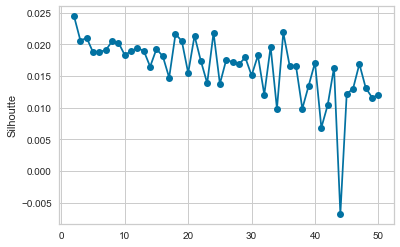

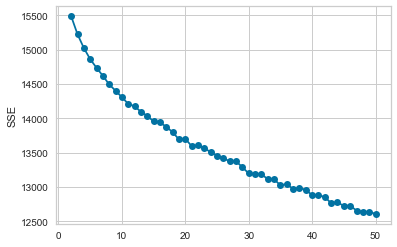

In [123]:
plt.plot(range(2, len(silhouette_list)+2), silhouette_list, marker='o')
plt.ylabel('Silhoutte')
plt.show()
plt.plot(range(2, len(sse_list)+2), sse_list, marker='o')
plt.ylabel('SSE')
plt.show()

In [124]:
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=300)
kmeans.fit(vectors)

KMeans(n_clusters=6)

In [125]:
centers=kmeans.cluster_centers_ # centroidi
labels=kmeans.labels_ # clusters labels
np.unique(labels, return_counts=True) 

(array([0, 1, 2, 3, 4, 5]), array([136, 170, 156, 209, 250,  99], dtype=int64))

In [126]:
len(centers)

6

In [127]:
for i in centers:
    print(w2v_model.wv.most_similar(i, topn=40))
    print("####################################################")

[('every_morning', 0.7189900875091553), ('lyric_song', 0.6705429553985596), ('podcasts', 0.6601090431213379), ('instantly', 0.6504858136177063), ('briefing', 0.6419265270233154), ('morning', 0.6357144117355347), ('trailer', 0.6144041419029236), ('shopping_list', 0.6112236380577087), ('news', 0.6067814826965332), ('lyric', 0.5999875068664551), ('check_weather', 0.5996097922325134), ('general', 0.5989190340042114), ('timer', 0.5971775650978088), ('see_lyric', 0.5970528721809387), ('reminder', 0.5960257053375244), ('versatile', 0.5922603607177734), ('trivia', 0.588829755783081), ('set_timer', 0.5854355096817017), ('appointment', 0.5825282335281372), ('weather', 0.5810787677764893), ('inexpensive', 0.5790438055992126), ('favorite_song', 0.5786653161048889), ('wake_morning', 0.5678490996360779), ('report', 0.5673784613609314), ('traffic', 0.565824568271637), ('recipe', 0.5606235265731812), ('radio_station', 0.5581851601600647), ('local', 0.5557796955108643), ('playing', 0.5524584054946899),

In [128]:
df = pd.DataFrame()

In [129]:
print(len(w2v["love"]))
print(len(centers[0])) # to check if the vectors have the same length

100
100


In [130]:
words = []
labels = []
cos = []
for w, label in zip(w2v, kmeans.labels_):
    words.append(w)
    labels.append(label)
    # this calculates the similarity bewtween centroids and all the words in their clusters
    cos_sim = dot(w2v[w], centers[label])/(norm(w2v[w])*norm(centers[label])) # cosine similarity formula (dot(a, b)/norm(a)*norm(b))
    cos.append(cos_sim)
    
df["word"] = words
df["labels"] = labels
df["cos"] = cos

print(df[df["labels"] == 1].sort_values(by = "cos", ascending = False).to_markdown()) # shows the most similar words to that cluster

|      | word             |   labels |      cos |
|-----:|:-----------------|---------:|---------:|
|  314 | year_old         |        1 | 0.635299 |
|  537 | dad              |        1 | 0.622274 |
|  509 | joke             |        1 | 0.617119 |
|  880 | listening        |        1 | 0.590806 |
|  532 | story            |        1 | 0.585267 |
|  860 | swipe            |        1 | 0.573866 |
|  390 | mom              |        1 | 0.572295 |
|  911 | skype            |        1 | 0.569547 |
|  464 | constantly       |        1 | 0.565829 |
|  864 | father_day       |        1 | 0.563923 |
| 1006 | dismiss          |        1 | 0.560894 |
|  825 | make_laugh       |        1 | 0.555411 |
|  460 | birthday         |        1 | 0.546747 |
|  357 | lol              |        1 | 0.545467 |
|  676 | child            |        1 | 0.544322 |
|  587 | grandkids        |        1 | 0.538832 |
|  773 | rock             |        1 | 0.531344 |
|  873 | elderly          |        1 | 0.531224 |


In [131]:
from sklearn.manifold import TSNE

In [132]:
tsne = TSNE(3, learning_rate="auto", metric="cosine")
tokens_list = []
for vec in w2v_model.wv.vectors:
    tokens_list.append(vec)

In [133]:
new_val = tsne.fit_transform(np.array(tokens_list))

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



In [134]:
df["x"] = [x[0] for x in new_val]
df["y"] = [x[1] for x in new_val]
df["z"] = [x[2] for x in new_val]

In [135]:
print(df[df["labels"] == 1].sort_values(by = "cos", ascending = False).to_markdown())

|      | word             |   labels |      cos |          x |          y |          z |
|-----:|:-----------------|---------:|---------:|-----------:|-----------:|-----------:|
|  314 | year_old         |        1 | 0.635299 |  49.9451   |   4.13536  |  -8.59012  |
|  537 | dad              |        1 | 0.622274 |  54.2783   |  -3.96296  |  -6.29564  |
|  509 | joke             |        1 | 0.617119 |  46.3618   |   3.48987  |   1.97658  |
|  880 | listening        |        1 | 0.590806 |  54.6391   |   1.67969  |  -1.4638   |
|  532 | story            |        1 | 0.585267 |  50.7331   |   5.56479  |   5.15293  |
|  860 | swipe            |        1 | 0.573866 |  33.8117   |  -7.04195  |  48.362    |
|  390 | mom              |        1 | 0.572295 |  50.6973   |  -3.858    |   0.310161 |
|  911 | skype            |        1 | 0.569547 |  49.618    |   4.63276  | -27.645    |
|  464 | constantly       |        1 | 0.565829 |  50.7826   |  10.076    |  -5.26559  |
|  864 | father_day  

In [136]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

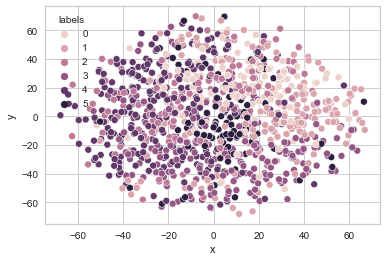

In [137]:
sns.scatterplot(data = df, x = "x", y = "y", hue = "labels")

In [138]:
import plotly_express as px

In [139]:
px.scatter_3d(data_frame = df, x = "x", y = "y", z = "z", color = [str(x) for x in df["labels"]], hover_name = "word")

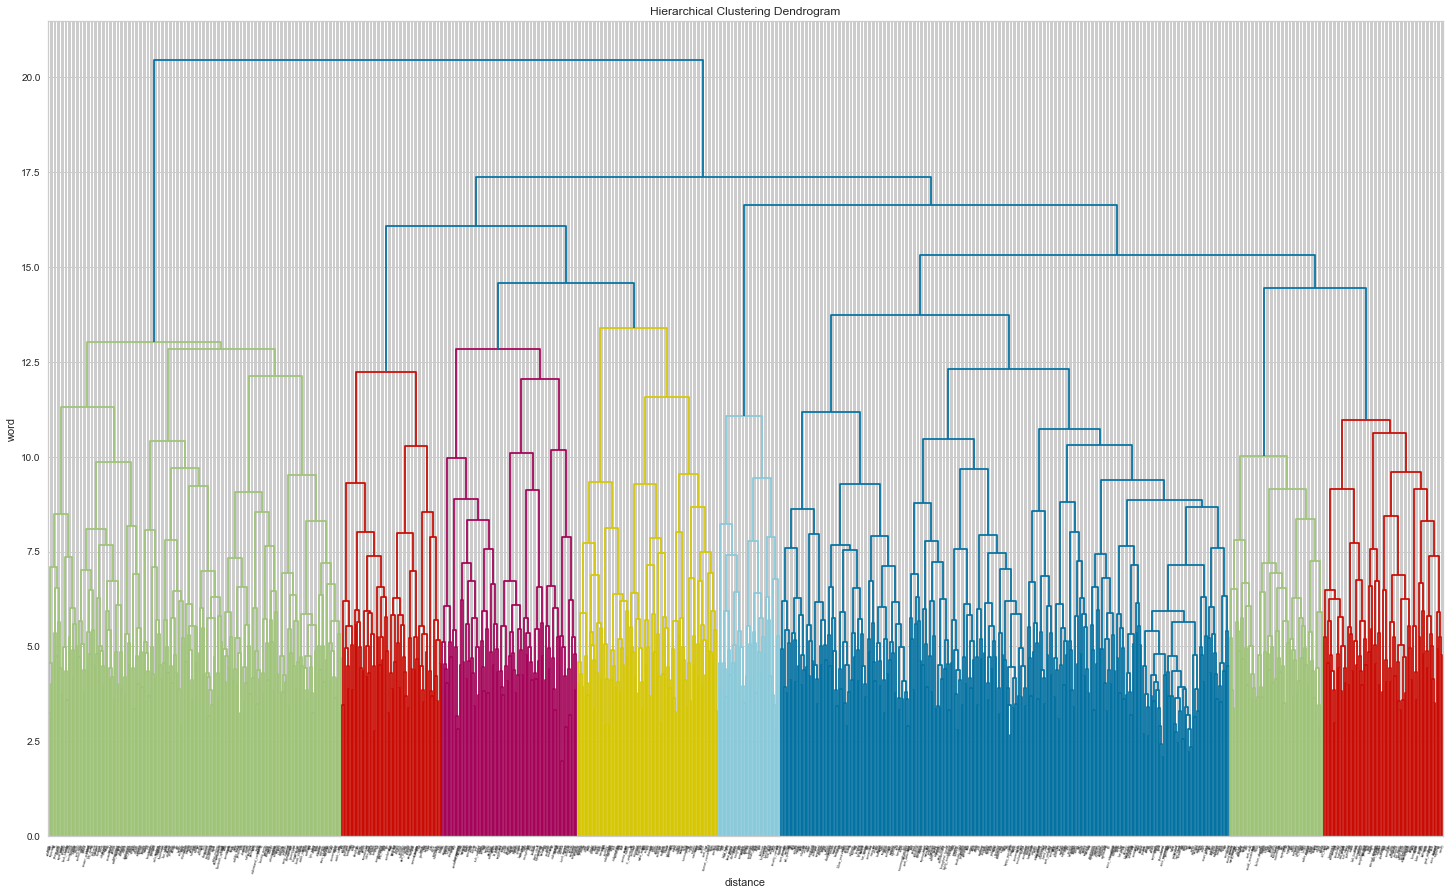

In [140]:
# distance_matrix = pairwise_distances(vectors, vectors, metric = "cosine")
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

l = linkage(w2v_model.wv.vectors, method='ward', metric='euclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=75.,  # rotates the x axis labels
    leaf_font_size=3.,  # font size for the x axis labels
    leaf_label_func=lambda v: str(w2v_model.wv.index_to_key[v])
)
plt.show()

In [141]:
hier_df = pd.DataFrame()

hier_labels = fcluster(l, 2, "maxclust")
hier_df["labels"] = hier_labels

hier_df["x"] = df["x"]
hier_df["y"] = df["y"]
hier_df["z"] = df["z"]
hier_df["word"] = df["word"]
print(hier_df[hier_df["labels"] == 4].to_markdown())

| labels   | x   | y   | z   | word   |
|----------|-----|-----|-----|--------|


In [142]:
px.scatter_3d(data_frame = hier_df, x = "x", y = "y", z = "z", color = [str(x) for x in hier_df["labels"]], hover_name = "word")

In [203]:
w2v_model.wv.most_similar(['love'], topn = 2000) #Nearest neighboor --> high cosine similarity

[('cool', 0.46211349964141846),
 ('sing', 0.44628605246543884),
 ('like', 0.4377390742301941),
 ('grand', 0.42574191093444824),
 ('father_day', 0.39760616421699524),
 ('really_enjoy', 0.39629554748535156),
 ('great', 0.3843739628791809),
 ('book', 0.3809807598590851),
 ('wonderful', 0.3732362985610962),
 ('watch_video', 0.3729255199432373),
 ('neat', 0.3673030734062195),
 ('cook', 0.36404818296432495),
 ('live', 0.3636825680732727),
 ('mother', 0.3629195988178253),
 ('favorite_song', 0.3595752716064453),
 ('lyric', 0.35899221897125244),
 ('grandchild', 0.35670360922813416),
 ('homework', 0.347608357667923),
 ('put', 0.3469661474227905),
 ('great_addition', 0.34494683146476746),
 ('one', 0.34227585792541504),
 ('play_game', 0.341775119304657),
 ('control_light', 0.34116819500923157),
 ('spot', 0.3389674723148346),
 ('fit', 0.3379497230052948),
 ('jump', 0.3374215364456177),
 ('gift', 0.33723971247673035),
 ('trailer', 0.336923748254776),
 ('bought', 0.33498522639274597),
 ('around_house

In [230]:
# THIS CALCULATES DISTANCES BEWTWEEN EACH WORD AND THE POSITIVE-NEGATIVE CENTROID

df_polarity = pd.DataFrame()

words = []
positive_centroid = "love"
negative_centroid = "error"
positive = []
negative = []

for w in w2v:
    words.append(w)
    pos = dot(w2v[w], w2v[positive_centroid])/(norm(w2v[w])*norm(w2v[positive_centroid]))
    neg = dot(w2v[w], w2v[negative_centroid])/(norm(w2v[w])*norm(w2v[negative_centroid]))
    # neg = 1-pos
    positive.append(pos)
    negative.append(neg)

df_polarity["word"] = words
df_polarity["pos_score"] = positive
df_polarity["neg_score"] = negative

df_polarity.sort_values(by = "neg_score", ascending = False).head(15)

,word,pos_score,neg_score
481,error,0.070178,1.000000
578,message,0.058275,0.563788
855,limit,0.173173,0.510281
479,stay,0.235874,0.507920
793,initially,0.144598,0.507605
984,connectivity,-0.058611,0.492443
1005,effort,0.096777,0.472572
222,may,0.091565,0.456735
232,trouble,0.179103,0.456236
983,none,-0.017329,0.455826


In [231]:
w2v_model.wv.most_similar(['love'], topn = 2000) #Nearest neighboor --> high cosine similarity

[('sing', 0.49555081129074097),
 ('grand', 0.4494123160839081),
 ('wonderful', 0.444284051656723),
 ('great', 0.443918913602829),
 ('cool', 0.4309692084789276),
 ('shopping_list', 0.4287492334842682),
 ('like', 0.4281421899795532),
 ('really_enjoy', 0.4269377887248993),
 ('timer', 0.39948636293411255),
 ('favorite_song', 0.39879855513572693),
 ('lyric', 0.3975685238838196),
 ('lyric_song', 0.39465731382369995),
 ('spot', 0.3911922872066498),
 ('play_game', 0.3905695974826813),
 ('remind', 0.3812062740325928),
 ('watch_video', 0.3774976432323456),
 ('man', 0.3765897750854492),
 ('trivia', 0.37468427419662476),
 ('live', 0.37267768383026123),
 ('shop', 0.371396541595459),
 ('put', 0.36782634258270264),
 ('father_day', 0.3670072853565216),
 ('homework', 0.3650173246860504),
 ('cook', 0.36440643668174744),
 ('neat', 0.3614019453525543),
 ('clean', 0.35921475291252136),
 ('nice', 0.35880690813064575),
 ('pleased', 0.35745951533317566),
 ('watching', 0.355514258146286),
 ('skype', 0.35505738

In [232]:
def scoring_function(x, pos_w, neg_w, w2v):
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    i = 0
    for review in bigrams_clean[x]:
        score = 0
        for w in review:
            try:
                vec = w2v[w]
                pos = dot(vec, w2v[pos_w])/(norm(vec)*norm(w2v[pos_w]))
                neg = dot(vec, w2v[neg_w])/(norm(vec)*norm(w2v[neg_w]))
                score += pos
                score -= neg
            except KeyError:
                continue
        if score > 0:
            predicted.append(1)
        elif score < 0:
            predicted.append(0)
        else:
            predicted.append(0)
        i+=1

    return predicted

In [233]:
def scoring_functionV3(x, pos_list, neg_list, w2v, stampa = True):
    import statistics
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    for review in bigrams_clean[x]:
        pos_score = 0
        neg_score = 0
        for w in review:
            pos_sim_list = []
            neg_sim_list = []
            try:
                vec = w2v[w]
            except KeyError:
                continue
            for w_pos, w_neg in zip(pos_list, neg_list):
                pos_sim = dot(vec, w2v[w_pos])/(norm(vec)*norm(w2v[w_pos]))
                neg_sim = dot(vec, w2v[w_neg])/(norm(vec)*norm(w2v[w_neg]))  
                pos_sim_list.append(pos_sim) 
                neg_sim_list.append(neg_sim)
            pos = statistics.mean(pos_sim_list)
            neg = statistics.mean(neg_sim_list)
            if stampa:
                print(w, "pos:", pos, "neg:", neg)
            pos_score += statistics.mean(pos_sim_list)
            neg_score += statistics.mean(neg_sim_list)

        if pos_score>neg_score:
            predicted.append(1)
        elif pos_score<neg_score:
            predicted.append(0)
        else:
            predicted.append(0)
    
    return predicted

In [234]:
target_pos = ["love", "enjoy", "work_perfectly", "lot_fun", "absolutely_love", "really_enjoy", "great"]
target_neg = ["trouble", "reset", "fix", "terrible", "disappointed"]

import statistics

df_score_v3 = pd.DataFrame()

words = []
pos_score = []
neg_score = []

for w, vec in w2v.items():
    pos_sim_list = []
    neg_sim_list = []
    for w_pos, w_neg in zip(target_pos, target_neg):
        pos_sim = dot(vec, w2v[w_pos])/(norm(vec)*norm(w2v[w_pos]))
        neg_sim = dot(vec, w2v[w_neg])/(norm(vec)*norm(w2v[w_neg]))  
        pos_sim_list.append(pos_sim) 
        neg_sim_list.append(neg_sim)
    pos = statistics.mean(pos_sim_list)
    neg = statistics.mean(neg_sim_list)
    words.append(w)
    pos_score.append(pos_sim)
    neg_score.append(neg_sim)

df_score_v3["words"] = words
df_score_v3["pos"] = pos_score
df_score_v3["neg"] = neg_score

df_score_v3.sort_values(by = "neg", ascending = False).head(15)

,words,pos,neg
221,disappointed,0.064219,1.000000
698,audio_quality,0.002844,0.471228
600,perform,0.070600,0.469577
695,currently,0.105995,0.404997
278,function,0.028872,0.403044
406,although,0.026546,0.399741
643,various,-0.056943,0.398088
989,nearly,0.190456,0.397702
610,impress,0.193599,0.384446
904,seamlessly,0.096369,0.378710


In [235]:
w2v_model.wv.most_similar(['love'], topn = 2000) #Nearest neighboor --> high cosine similarity

[('sing', 0.49555081129074097),
 ('grand', 0.4494123160839081),
 ('wonderful', 0.444284051656723),
 ('great', 0.443918913602829),
 ('cool', 0.4309692084789276),
 ('shopping_list', 0.4287492334842682),
 ('like', 0.4281421899795532),
 ('really_enjoy', 0.4269377887248993),
 ('timer', 0.39948636293411255),
 ('favorite_song', 0.39879855513572693),
 ('lyric', 0.3975685238838196),
 ('lyric_song', 0.39465731382369995),
 ('spot', 0.3911922872066498),
 ('play_game', 0.3905695974826813),
 ('remind', 0.3812062740325928),
 ('watch_video', 0.3774976432323456),
 ('man', 0.3765897750854492),
 ('trivia', 0.37468427419662476),
 ('live', 0.37267768383026123),
 ('shop', 0.371396541595459),
 ('put', 0.36782634258270264),
 ('father_day', 0.3670072853565216),
 ('homework', 0.3650173246860504),
 ('cook', 0.36440643668174744),
 ('neat', 0.3614019453525543),
 ('clean', 0.35921475291252136),
 ('nice', 0.35880690813064575),
 ('pleased', 0.35745951533317566),
 ('watching', 0.355514258146286),
 ('skype', 0.35505738

In [236]:
def scoring_functionV4(x, pos_list, neg_list, w2v, stampa = True):
    import statistics
    bigrams_clean = Phrases(x)
    # print(clean)
    predicted = []
    average_pos = np.copy(w2v_model.wv.get_vector(pos_list[0]))
    average_neg = np.copy(w2v_model.wv.get_vector(neg_list[0]))
    for w_pos, w_neg in zip(pos_list[1:], neg_list[1:]):
            average_pos += w2v_model.wv.get_vector(w_pos)
            average_neg += w2v_model.wv.get_vector(w_neg)

    for review in bigrams_clean[x]:
        pos_score = 0
        neg_score = 0
        for w in review:
            try:
                vec = w2v[w]
            except KeyError:
                continue

            pos = dot(vec, average_pos)/(norm(vec)*norm(average_pos))
            neg = dot(vec, average_neg)/(norm(vec)*norm(average_neg))


            if stampa:
                print(w, "pos:", pos, "neg:", neg)
            pos_score += pos
            neg_score += neg

        if pos_score>neg_score:
            predicted.append(1)
        elif pos_score<neg_score:
            predicted.append(0)
        else:
            predicted.append(0)
    
    return predicted

In [239]:
y = []
x = []

dataset.drop(dataset[dataset.rating == 3].index, inplace=True) #droppa recensioni con 3-4 stelle
dataset.drop(dataset[dataset.rating == 4].index, inplace=True)
dataset_test = create_balanced_dataset(dataset)
for feedback, review in zip(dataset_test["feedback"], dataset_test["verified_reviews"]):
    y.append(feedback)
    x.append(review)
    
x_test = tokenize_list_of_text(x, custom_stopwords, False, pos_list)[1]

1    257
0    257
Name: feedback, dtype: int64
total number of tokens extracted are: 2152


In [240]:
target_pos = ["love", "enjoy", "work_perfectly", "great", "awesome", "cool"]
target_neg = ["trouble", "reset", "fix", "error"]
predicted = scoring_function(x_test, "love", "trouble", w2v.copy())
print(classification_report(y, predicted))
predicted = scoring_functionV3(x_test, target_pos, target_neg, w2v.copy(), stampa = False)
print(classification_report(y, predicted))
predicted = scoring_functionV4(x_test, target_pos, target_neg, w2v.copy(), stampa = False)
print(classification_report(y, predicted))

              precision    recall  f1-score   support

           0       0.83      0.49      0.62       257
           1       0.64      0.90      0.75       257

    accuracy                           0.70       514
   macro avg       0.74      0.70      0.68       514
weighted avg       0.74      0.70      0.68       514

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       257
           1       0.71      0.85      0.78       257

    accuracy                           0.75       514
   macro avg       0.76      0.75      0.75       514
weighted avg       0.76      0.75      0.75       514

              precision    recall  f1-score   support

           0       0.85      0.65      0.73       257
           1       0.71      0.88      0.79       257

    accuracy                           0.76       514
   macro avg       0.78      0.76      0.76       514
weighted avg       0.78      0.76      0.76       514



In [241]:
for pred, review, correct in zip(predicted, x, y):
    print("prediction:", pred, "true label:", correct)
    print(review)
    print("################")

prediction: 1 true label: 1
Incredible piece of technology.I have this right center of my living room on an island kitchen counter. The mic and speaker goes in every direction and the quality of the sound is quite good. I connected the Echo via Bluetooth to my Sony soundbar on my TV but find the Echo placement and 360 sound more appealing. It's no audiophile equipment but there is good range and decent bass. The sound is more than adequate for any indoor entertaining and loud enough to bother neighbors in my building. The knob on the top works great for adjusting volume. This is my first Echo device and I would imagine having to press volume buttons (on the Echo 2) a large inconvenience and not as precise. For that alone I would recommend this over the regular Echo (2nd generation).The piece looks quality and is quite sturdy with some weight on it. The rubber material on the bottom has a good grip on the granite counter-- my cat can even rub her scent on it without tipping it over.This

In [77]:
negation_handler(["not", "satisfied"])

['fall_short_of']

In [78]:
stringa = """I'm not satisfied"""

In [79]:
x = tokenize_list_of_text([stringa], custom_stopwords, False, pos_list)[1]
scoring_functionV3(x, target_pos, target_neg, w2v)

total number of tokens extracted are: 1


[0]

In [80]:
w2v_model.wv.most_similar(['love'], topn = 2000)

[('wonderful', 0.49373799562454224),
 ('like', 0.48880288004875183),
 ('cool', 0.4812116324901581),
 ('great', 0.47611600160598755),
 ('grand', 0.43974584341049194),
 ('really_enjoy', 0.43707016110420227),
 ('play_game', 0.4344007968902588),
 ('neat', 0.42718327045440674),
 ('man', 0.41563403606414795),
 ('wife', 0.4123576581478119),
 ('skype', 0.39438846707344055),
 ('trivia', 0.39388272166252136),
 ('sing', 0.39336156845092773),
 ('best', 0.39124059677124023),
 ('pleased', 0.3887846767902374),
 ('convenient', 0.38357308506965637),
 ('lyric', 0.3793617784976959),
 ('ease', 0.3793087899684906),
 ('delivery', 0.3770938515663147),
 ('spot', 0.37699946761131287),
 ('playing', 0.3735332190990448),
 ('set_timer', 0.3704332113265991),
 ('guest', 0.3669581413269043),
 ('absolutely_love', 0.36618703603744507),
 ('shopping_list', 0.36468127369880676),
 ('game', 0.3640870451927185),
 ('lyric_song', 0.36202073097229004),
 ('father_day', 0.35820233821868896),
 ('nice', 0.35710206627845764),
 ('con

In [81]:
nltk.tokenize.word_tokenize("didn't")

['did', "n't"]